# Model Building [Mock]

## Import Modules

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, 
                             accuracy_score, 
                             confusion_matrix,
                             ConfusionMatrixDisplay, 
                             classification_report)
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from teaching_tools.widgets import ConfusionMatrixWidget

## Load data

In [105]:
file = "expanded_sample.csv"
test_df = pd.read_csv(file)
test_df.head()

,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,cgpa_before,cgpa_after,employment,quit_job,cgpa_change
0,400level,22–24,Female,Single,Management Science,Finance,Yes,Neutral,Poor,Neutral,Poor,Good,Neutral,3.868576,3.521037,Yes,No,-0.347539
1,300level,19–21,Male,Single,Science,Statistics,Yes,Good,Good,Good,Good,Good,Good,3.852298,4.567279,Yes,No,0.714981
2,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,4.169165,4.050938,No,No,-0.118227
3,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,3.537479,3.684619,No,No,0.147139
4,200level,16–18,Female,Married,Engineering,Civil Engineering,No,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,4.087705,3.683059,Yes,No,-0.404646


## Build Models

### Linear Regression

In [106]:
linear_reg_df = test_df.drop(columns=["cgpa_before", "cgpa_after"])

In [107]:
# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_df = encoder.fit_transform(linear_reg_df.drop(columns="cgpa_change"))
encoded_df = pd.DataFrame(encoded_df.toarray(), columns=encoder.get_feature_names_out(linear_reg_df.drop(columns="cgpa_change").columns))
linear_reg_df = pd.concat([linear_reg_df, encoded_df], axis=1)

#### Select features and target

In [108]:
target = "cgpa_change"
X_linear_reg = linear_reg_df.drop(columns=target)
y_linear_reg = linear_reg_df[target]

# Going forward linear regresion will be abreviated to lr

In [109]:
over_sampler = RandomOverSampler(random_state=42)
# X_linear_reg, y_linear_reg = over_sampler.fit_resample(X_linear_reg, y_linear_reg)
# X_linear_reg.head()

Split data into test and training sets

In [110]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_linear_reg, y_linear_reg, test_size=0.2, random_state=42)

Split training data into training and validation data

In [111]:
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
        X_train_lr, y_train_lr, test_size=0.2, random_state=42
)

Make pipeline

In [112]:
# create the column transformer to one-hot encode the categorical features
categorical_features = X_linear_reg.columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

In [113]:
# create the linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])


# fit the model to the training data
model.fit(X_train_lr, y_train_lr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['level', 'age', 'gender', 'marital_status', 'faculty', 'department',
       'skill', 'prep_before', 'prep_after', 'quality_before', 'quality_after',
       'confidence_before', 'confidence_after', 'employment', 'quit_job',
       'level_200level', 'level_300level', 'lev...
       'quality_before_Good', 'quality_before_Neutral', 'quality_before_Poor',
       'quality_after_Good', 'quality_after_Neutral', 'quality_after_Poor',
       'confidence_before_Good', 'confidence_before_Neutral',
       'confidence_after_Good', 'confidence_after_Neutral',
       'confidence_after_Poor', 'employment_No', 'employment_Yes',
       'quit_job_No', 'quit_job_Yes', 'quit_job_nan'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [114]:
# evaluate the model's performance on the training data
y_train_lr_mean = y_train_lr.mean()
y_train_lr_baseline = [y_train_lr_mean]*len(y_train_lr)
baseline_mse = mean_squared_error(y_train_lr, y_train_lr_baseline)
training_mse = mean_squared_error(y_train_lr, model.predict(X_train_lr))
print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}""")


Baseline MSE: 0.20356 
Training MSE: 0.20137


In [115]:
# predict the target variable for the validation data
y_pred_val = model.predict(X_val_lr)


# evaluate the model's performance on the validation data
y_val_mean = y_val_lr.mean()
y_val_baseline = [y_val_mean]*len(y_val_lr)
val_mse = mean_squared_error(y_val_lr, y_pred_val)

print(f"""
Baseline MSE: {round(baseline_mse, 5)} 
Training MSE: {round(training_mse, 5)}
Validation MSE: {round(val_mse, 5)}""")


Baseline MSE: 0.20356 
Training MSE: 0.20137
Validation MSE: 0.21994


In [116]:
# perform k-fold cross-validation

scores = cross_val_score(model, X_linear_reg, y_linear_reg, cv=5, scoring='neg_mean_squared_error')

# calculate the mean and standard deviation of the scores
mean_mse = np.mean(-scores)
std_mse = np.std(-scores)

# print the mean and standard deviation of the scores
print(f"Mean MSE: {mean_mse:.5f}")
print(f"Standard deviation of MSE: {std_mse:.5f}")

Mean MSE: 0.20357
Standard deviation of MSE: 0.00945


Text(0, 0.5, 'Residuals')

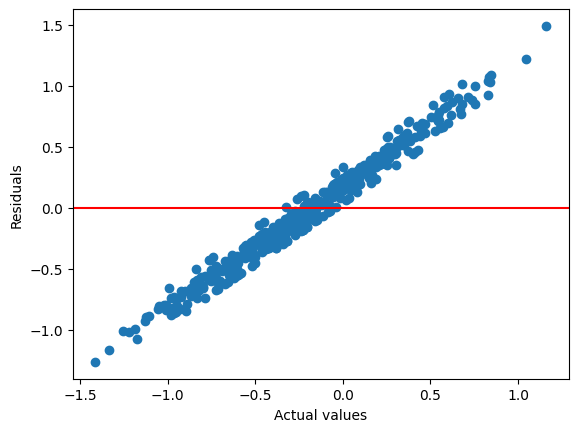

In [117]:
# calculate the residuals
residuals = y_val_lr - y_pred_val

# plot the residuals
plt.scatter(y_val_lr, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual values')
plt.ylabel('Residuals')

In [118]:
# evaluate the model's performance on the test data
mse = mean_squared_error(y_val_lr, y_pred_val)
mse

0.21994373512983717

### Decision Tree Classifier

### Recategorise data

Check only if CGPA dropped or not.

In [119]:
def rise_or_drop(val):  
    """
    This function splits the given column into two catgories one based on the direction of the number
    (Positive or Negative)
    val: This function is designed to be used with series.apply so no input is needed here.
    """    
    
    if val > 0:
        category= False # CGPA rose
    else:
        category= True # CGPA dropped
    
    return category

In [120]:
def categorize_change(val):
    """
    This function splits the given column into 6 catgories based on the magnitude of the difference in the val column.
    val: This function is designed to be used with series.apply so no input is needed here.
    """    
    
    category = ""

    if abs(val) >= 1:
        category+="EXTREME"
    elif abs(val) >= 0.5:
        category+="VERY HIGH"
    elif abs(val) >= 0.2:
        category+="HIGH"
    elif abs(val) >= 0.1:
        category+="MEDIUM"
    elif abs(val) >= 0.05:
        category+="LOW"
    else:
        category+=" VERY LOW"
        
    if val > 0:
        category+= "-RISE"
    else:
        category+= "-DROP"
    
    return category

In [121]:
categorical_df = test_df.drop(columns=["cgpa_before", "cgpa_after"])

categorical_df["cgpa_drop"] = categorical_df["cgpa_change"].apply(rise_or_drop)

categorical_df.drop(columns=["cgpa_change", "quit_job"], inplace=True)

categorical_df[categorical_df.select_dtypes("object").columns] = categorical_df.select_dtypes(
    "object").astype("category")
categorical_df.dtypes

level                category
age                  category
gender               category
marital_status       category
faculty              category
department           category
skill                category
prep_before          category
prep_after           category
quality_before       category
quality_after        category
confidence_before    category
confidence_after     category
employment           category
cgpa_drop                bool
dtype: object

In [122]:
target = "cgpa_drop"
X_decision_tree = categorical_df.drop(columns=target)
y_decision_tree = categorical_df[target]

# Going forward decision tree will be abreviated to dt

In [123]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt= train_test_split(X_decision_tree, y_decision_tree, test_size=0.2, random_state=42)

In [124]:
# Importing the necessary libraries
from imblearn.over_sampling import RandomOverSampler

# Initializing the RandomOverSampler with a fixed random_state for reproducibility
over_sampler = RandomOverSampler(random_state=42)

# Resampling the training data to balance the target classes
X_train_over_dt, y_train_over_dt = over_sampler.fit_resample(X_train_dt, y_train_dt)

# Printing the shape of the resampled training data
print("X_train_over shape:", X_train_over_dt.shape)

# Displaying the first few rows of the resampled training data
X_train_over_dt.head()


X_train_over shape: (2942, 14)


,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,employment
0,500level.,27+,Female,Married,Engineering,Met and mat,Yes,Good,Neutral,Good,Neutral,Neutral,Neutral,No
1,300level,22–24,Male,Single,Education,Educational foundations,No,Neutral,Good,Neutral,Neutral,Neutral,Neutral,Yes
2,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,No
3,400level,19–21,Male,Single,Engineering,Electrical and Electronics Engineering,Yes,Poor,Good,Neutral,Neutral,Neutral,Neutral,Yes
4,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,No


In [125]:
# Calculating the baseline accuracy for the binary classification problem
# Baseline accuracy is the accuracy achieved by always predicting the majority class

# Counting the frequency of each class in the target variable 'y_train_dt'
class_counts = y_train_dt.value_counts()

# Calculating the percentage of the majority class in the target variable
baseline_accuracy = class_counts.max() / len(y_train_dt)

# Rounding the baseline accuracy to two decimal places for better readability
rounded_baseline_accuracy = round(baseline_accuracy, 2)

# Printing the baseline accuracy
print("Baseline Accuracy:", rounded_baseline_accuracy)


Baseline Accuracy: 0.66


In [126]:
# Create empty lists for training and validation accuracy scores
training_acc = []
depth_hyperparams = range(1, 50, 2)

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = model = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train_dt, y_train_dt)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train_dt, y_train_dt))

# max_train_acc = max(validation_acc)
# optimal_depth = validation_acc.index(max_val_acc) + 6
print("Training Accuracy Scores:", training_acc[:3])
# print("Validation Accuracy Scores:", validation_acc[:3])
# print("Max Validation Accuracy Score:", max_val_acc)
# print("Optimal Depth:", optimal_depth)

Training Accuracy Scores: [0.6566964285714286, 0.6566964285714286, 0.6566964285714286]


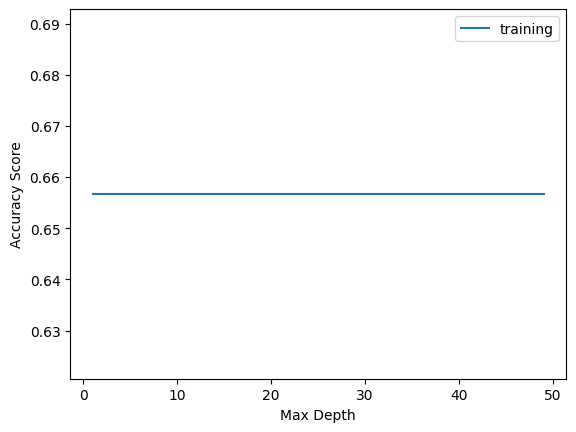

In [127]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
# plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [128]:
# Creating a Decision Tree model using a pipeline with OrdinalEncoder as a preprocessor

# Step 1: Preprocessing the features with OrdinalEncoder
# OrdinalEncoder is used to convert categorical features into ordinal integers.
# It is appropriate for features with a natural order, such as education levels or rankings.

# Step 2: Creating the Decision Tree Classifier model
# DecisionTreeClassifier is used as the classification model for this pipeline.
# It will learn to classify data based on the ordinal-encoded features.

# Step 3: Combining preprocessing and model into a pipeline
# We use the make_pipeline function to create a pipeline that sequentially applies
# OrdinalEncoder to preprocess the features and then trains the DecisionTreeClassifier.

# Step 4: Fitting the model on the training data
# We use the fit method to train the dt_model on the X_train_dt (features) and y_train_dt (target).

# Note: The random_state parameter is set to 42 to ensure reproducibility of results.

# Final Note: The trained model is now ready to make predictions on new data.

# Code Block:
# Creating the pipeline with OrdinalEncoder and DecisionTreeClassifier
dt_model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(random_state=42)
)

# Fitting the model on the training data
dt_model.fit(X_train_dt, y_train_dt)


Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [129]:
# Define a dictionary 'param_grid' for hyperparameter tuning of DecisionTreeClassifier.

# The hyperparameters to tune are:
# 1. max_depth: The maximum depth of the decision tree. It controls the depth of the tree,
#               and higher values may lead to overfitting.
# 2. min_samples_leaf: The minimum number of samples required to be at a leaf node.
#                      It controls the minimum size of leaf nodes, which helps to avoid overfitting.
# 3. min_samples_split: The minimum number of samples required to split an internal node.
#                       It controls the minimum size of internal nodes before a split, preventing overfitting.

# We create a dictionary 'param_grid' with three keys, each corresponding to a hyperparameter.
# The values associated with each key are lists of hyperparameter values to be tried during tuning.

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 4, 5, 6, 7],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5, 6]
}

# The 'param_grid' dictionary is now ready to be used in hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV.


{'decisiontreeclassifier__max_depth': [3, 4, 5, 6, 7],
 'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
 'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5, 6]}

In [130]:
# Create a GridSearchCV object
grid_search = GridSearchCV(dt_model, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_over_dt, y_train_over_dt)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': [3, 4, 5, 6, 7],
                         'decisiontreeclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5],
                         'decisiontreeclassifier__min_samples_split': [2, 3, 4,
                                                                       5, 6]})

In [131]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__min_samples_leaf,param_decisiontreeclassifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,0.019548,0.004720,0.005386,0.000474,6,3,4,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
98,0.015365,0.001368,0.004782,0.001734,6,5,5,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
97,0.016129,0.001835,0.004210,0.000741,6,5,4,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
96,0.017153,0.001584,0.004975,0.001413,6,5,3,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
95,0.018736,0.001936,0.006596,0.001735,6,5,2,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
94,0.023921,0.018014,0.006206,0.001164,6,4,6,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
93,0.014953,0.000620,0.003996,0.000620,6,4,5,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
92,0.019941,0.003032,0.005784,0.001814,6,4,4,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
91,0.016343,0.002568,0.005202,0.001470,6,4,3,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1
90,0.013756,0.000990,0.004587,0.001186,6,4,2,"{'decisiontreeclassifier__max_depth': 6, 'deci...",0.519525,0.480475,0.520408,0.528912,0.547619,0.519388,0.021922,1


In [132]:
grid_search.best_params_

{'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [133]:
# Calculate and display the training and validation accuracies of the model.

# 'model' is the trained decision tree model, which has been fitted on the oversampled training data.

# Calculate the training accuracy of the model on the oversampled training data.
# The method 'score' of the trained model returns the mean accuracy on the given data and labels.
# Here, 'X_train_over_dt' represents the feature matrix of the oversampled training data,
# and 'y_train_over_dt' represents the corresponding target labels.
# The calculated accuracy is assigned to the variable 'acc_train'.
acc_train = model.score(X_train_over_dt, y_train_over_dt)

# Calculate the validation accuracy of the model on the validation (test) data.
# Similarly, 'X_test_dt' represents the feature matrix of the test data,
# and 'y_test_dt' represents the corresponding target labels.
# The calculated accuracy is assigned to the variable 'acc_test'.
acc_test = model.score(X_test_dt, y_test_dt)

# Display the training accuracy and validation accuracy in a user-friendly format.
# The 'round' function is used to round the accuracy values to 4 decimal places for better readability.
print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))


Training Accuracy: 0.5
Validation Accuracy: 0.6964


In [134]:
# Calculate and display the training accuracy and validation accuracy of the decision tree model.

# 'dt_model' is the trained decision tree model, which is created as a pipeline with an ordinal encoder for preprocessing.
# It has been fitted on the training data represented by 'X_train_dt' (feature matrix) and 'y_train_dt' (target labels).

# Calculate the training accuracy of the decision tree model.
# The 'predict' method of the trained model 'dt_model' is used to make predictions on the training data 'X_train_dt'.
# The 'accuracy_score' function is then used to compare the predicted labels with the true labels 'y_train_dt'
# and calculate the training accuracy.
# The calculated accuracy is assigned to the variable 'acc_train'.
acc_train = accuracy_score(y_train_dt, dt_model.predict(X_train_dt))

# Calculate the validation accuracy of the decision tree model.
# The 'score' method of the trained model 'dt_model' is used to calculate the mean accuracy on the validation data 'X_test_dt'
# and the corresponding target labels 'y_test_dt'.
# The calculated accuracy is assigned to the variable 'acc_val'.
acc_val = dt_model.score(X_test_dt, y_test_dt)

# Display the training accuracy and validation accuracy in a user-friendly format.
# The 'round' function is used to round the accuracy values to 2 decimal places for better readability.
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))


Training Accuracy: 0.66
Validation Accuracy: 0.7


In [135]:
# Extract feature importances from the trained decision tree model and display the top five important features.

# 'X_train_dt' represents the feature matrix of the training data used to train the decision tree model.
# 'features' is a list containing the names of all the features in the feature matrix.

# Extract feature importances from the decision tree model.
# The 'named_steps' attribute of 'dt_model' provides access to the individual components of the pipeline.
# 'dt_model.named_steps["decisiontreeclassifier"]' accesses the trained decision tree classifier from the pipeline.
# The 'feature_importances_' attribute of the decision tree classifier provides the importance scores of each feature.
# The importance scores are assigned to the variable 'importances'.
importances = dt_model.named_steps["decisiontreeclassifier"].feature_importances_

# Create a pandas Series to pair feature names with their corresponding importance scores.
# The 'pd.Series' constructor is used to create a Series object with 'importances' as the data and 'features' as the index.
# The 'index' parameter ensures that the feature names are used as the index of the Series.
# The resulting Series 'feat_imp' is sorted in ascending order based on the importance scores using the 'sort_values' method.
feat_imp = pd.Series(importances, index=features).sort_values()

# Display the top five important features.
# The 'tail' method is used to select the last five entries of 'feat_imp', which represent the top five features with the highest importance scores.
print(feat_imp.tail())


faculty        0.033810
prep_before    0.048065
level          0.079878
skill          0.379009
age            0.387404
dtype: float64

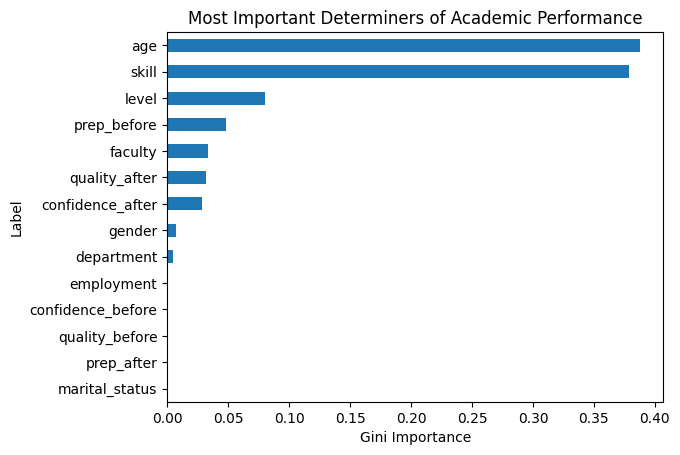

In [136]:
# Create horizontal bar chart of feature importances
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title("Most Important Determiners of Academic Performance");

In [137]:
predictions = dt_model.predict(X_test_dt)

accuracy_score(predictions, y_test_dt)

0.6964285714285714

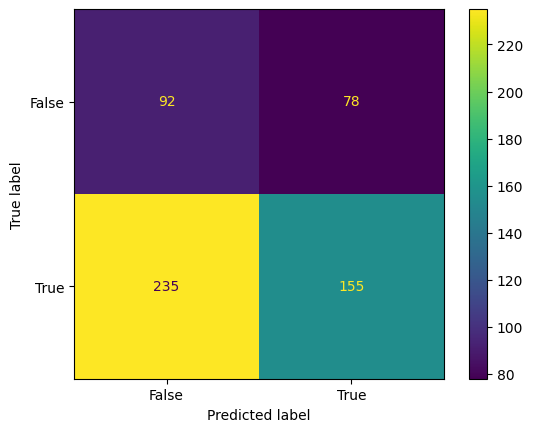

In [138]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test_dt, y_test_dt)

In [139]:
print(classification_report(y_test_dt, model.predict(X_test_dt)))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00       170
        True       0.70      1.00      0.82       390

    accuracy                           0.70       560
   macro avg       0.35      0.50      0.41       560
weighted avg       0.49      0.70      0.57       560



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [140]:
c = ConfusionMatrixWidget(model, X_test_dt, y_test_dt)
c.show()

FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0)

## Gradient Boosting Classifier

In [141]:
target = "cgpa_drop"
X = categorical_df.drop(columns=target)
y = categorical_df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2800, 14)
y shape: (2800,)


In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2240, 14)
y_train shape: (2240,)
X_test shape: (560, 14)
y_test shape: (560,)


In [143]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (2942, 14)


,level,age,gender,marital_status,faculty,department,skill,prep_before,prep_after,quality_before,quality_after,confidence_before,confidence_after,employment
0,500level.,27+,Female,Married,Engineering,Met and mat,Yes,Good,Neutral,Good,Neutral,Neutral,Neutral,No
1,300level,22–24,Male,Single,Education,Educational foundations,No,Neutral,Good,Neutral,Neutral,Neutral,Neutral,Yes
2,400level,22–24,Male,Single,Science,Geophysics,No,Poor,Neutral,Neutral,Poor,Neutral,Poor,No
3,400level,19–21,Male,Single,Engineering,Electrical and Electronics Engineering,Yes,Poor,Good,Neutral,Neutral,Neutral,Neutral,Yes
4,300level,25–27,Male,Single,Science,Botany,Yes,Good,Neutral,Neutral,Poor,Good,Neutral,No


In [144]:
y_train_over.value_counts(normalize=True)

True     0.5
False    0.5
Name: cgpa_drop, dtype: float64

In [145]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.6567


In [146]:
clf = make_pipeline(
    OrdinalEncoder(), GradientBoostingClassifier()
)

In [147]:
params = {
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params


{'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [148]:
model = GridSearchCV(clf, param_grid=params, verbose=1, n_jobs=-1, cv=5)
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [149]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.100132,0.009764,0.009774,0.003645,3,20,"{'gradientboostingclassifier__max_depth': 3, '...",0.528014,0.466893,0.520408,0.528912,0.547619,0.518369,0.027253,1
4,0.099733,0.012471,0.008377,0.001017,3,25,"{'gradientboostingclassifier__max_depth': 3, '...",0.528014,0.466893,0.520408,0.528912,0.547619,0.518369,0.027253,1
5,0.104719,0.002958,0.009774,0.003420,3,30,"{'gradientboostingclassifier__max_depth': 3, '...",0.519525,0.466893,0.520408,0.528912,0.547619,0.516671,0.026861,3
6,0.089161,0.003314,0.008976,0.001093,4,20,"{'gradientboostingclassifier__max_depth': 4, '...",0.519525,0.466893,0.520408,0.528912,0.547619,0.516671,0.026861,3
7,0.103921,0.003362,0.007779,0.000746,4,25,"{'gradientboostingclassifier__max_depth': 4, '...",0.519525,0.466893,0.520408,0.528912,0.547619,0.516671,0.026861,3
8,0.214620,0.036168,0.011170,0.002777,4,30,"{'gradientboostingclassifier__max_depth': 4, '...",0.519525,0.466893,0.520408,0.528912,0.547619,0.516671,0.026861,3
1,0.083776,0.002959,0.008577,0.001017,2,25,"{'gradientboostingclassifier__max_depth': 2, '...",0.512733,0.466893,0.517007,0.528912,0.539116,0.512932,0.024808,7
2,0.103324,0.015433,0.012168,0.003908,2,30,"{'gradientboostingclassifier__max_depth': 2, '...",0.512733,0.466893,0.513605,0.528912,0.539116,0.512252,0.024733,8
0,0.094747,0.010574,0.017953,0.005606,2,20,"{'gradientboostingclassifier__max_depth': 2, '...",0.512733,0.466893,0.510204,0.525510,0.544218,0.511912,0.025530,9


In [150]:
model.best_params_

{'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 20}

In [151]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))


Training Accuracy: 0.5401
Validation Accuracy: 0.4411


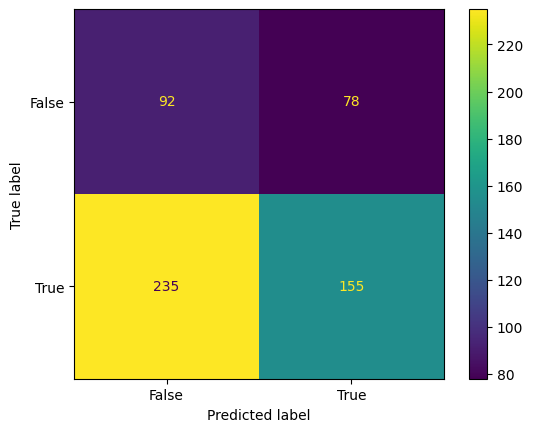

In [152]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [162]:
print(classification_report(y_test, model.predict(X_test)))
# classification_report(y_test, model.predict(X_test)).split()


              precision    recall  f1-score   support

       False       0.28      0.54      0.37       170
        True       0.67      0.40      0.50       390

    accuracy                           0.44       560
   macro avg       0.47      0.47      0.43       560
weighted avg       0.55      0.44      0.46       560



In [1]:
def make_cnf_matrix(threshold):
    """_ignore this function, it's not used and it's not properly built
    """
    y_predict_proba = model.predict_proba(X_test)[:, 1]
    y_pred = y_predict_proba > threshold
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=True)
    precision = classification_report(y_test, y_pred).split()[10]
    recall = classification_report(y_test, y_pred).split()[11]
    accuracy = classification_report(y_test, y_pred).split()[15]
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")


thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.01)

interact(make_cnf_matrix, threshold=thresh_widget)


NameError: name 'widgets' is not defined